# Construction of a prediction model for Covid19
## Part 2 (for part one look at the DataExploration notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from WebApp.CovidClinicalData import DataImputer

from scipy.stats import ttest_ind
from scipy.stats import chisquare
from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

We read the data file created in the Part 1 notebook

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


We are going to split the data into a training set on which we will do the parameter tuning and a test set on which we will evaluate the models' performance

In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]
X, test_x, y, test_y = train_test_split(X, y, stratify=y)
print(y.value_counts(normalize=True))

Negative    0.976976
Positive    0.023024
Name: covid19_test_results, dtype: float64


## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [4]:
def reduce_training_set(data_x, data_y, ratio=1):
    '''
    Undersamples the 'Negative' classes so we end up with nPositives * ratio 'Negative' examples
    '''
    
    if ratio < 1: return data_x
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum() * ratio)
    all_positives = data_x[data_y == "Positive"]
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    '''
        Gets evaluation metrics for a set of predictions
        values: a tuple in the form of '(actual, predictions)'
    '''
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [5]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [29]:
def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, 
                                  thresholds=np.linspace(0,1,num=11), sample_weights=None):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = data_y[data_y == "Negative"].shape[0]
    negs_to_sample = min(positive_index.shape[0] * ratio_negatives_to_positives, size_of_negatives) if ratio_negatives_to_positives >=1 else size_of_negatives
    
    fold_size = positive_index.shape[0] // folds if folds > 1 else positive_index.shape[0] // 10 #If we just want 1 fold, we just make the training set 90% of the data
    
    #The next couple of lines are just used for undersampling
    training_size_neg = fold_size * ratio_negatives_to_positives if negs_to_sample < size_of_negatives else size_of_negatives // folds    
    negs_to_sample = negs_to_sample - training_size_neg if negs_to_sample - training_size_neg > 0 else (negs_to_sample // 10) * 9 #If we just want 1 fold, we just make the training set 90% of the data
    
    fold_size_neg = (size_of_negatives //positive_index.shape[0]) * fold_size #We preserve population proportion in the validation set(fold_size represents the number of positives in the validation set)
    #fold_size_neg = (trainin_size_neg)
    
    results = np.zeros((folds,2)) #Shape of folds, training and validation, and number of metrics   
    threshold_results = np.zeros((folds, thresholds.shape[0]))
    
    reminder = positive_index.shape[0] % folds
    
    imputer = DataImputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1   
        
        #If ratio is greater or equal than 0 then it is undersampling (0 for no sampling)
        if ratio_negatives_to_positives >= 0:
            training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set

            # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
            train_x = pd.concat([data_x[data_y == "Negative"].sample(negs_to_sample), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
            train_y = data_y[train_x.index]

            rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
            valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size_neg), data_x.loc[positive_index[start:end]]], axis=0) 
            valid_y = data_y[valid_x.index]
            
            train_x = imputer.fit_transform(train_x, train_y)
            
        else:
        
            valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size_neg), data_x.loc[positive_index[start:end]]], axis=0) 
            valid_y = data_y[valid_x.index]
            
            rest_of_x = data_x.loc[~data_x.index.isin(valid_x.index)] ## Al data not used by training
            train_x = imputer.fit_transform(rest_of_x, data_y[rest_of_x.index])
            
            smote = SMOTE(sampling_strategy=1/(ratio_negatives_to_positives * -1))
                        
            train_x, train_y = smote.fit_resample(train_x, data_y[train_x.index])
                    
        valid_x = imputer.transform(valid_x)
                
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        #This looks a little bit complex, but basically we create num_thresholds arrays (one for each threshold)
        #and evaluate them using f1_scores and put them on the threshold_results for the corresponding fold
        #which will be converted into a mean when we return it.
        threshold_results[i] += [f1_score(valid_y, pd.cut(v_pred_prob, [-1, x, 1.1], 
                                                          right=False, labels=["Negative", "Positive"]), pos_label="Positive") for x in thresholds]
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += f1_score(*train_v, pos_label="Positive") ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += f1_score(*valid_v, pos_label="Positive") ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    return results.mean(axis=0), results.std(ddof=1, axis=0), threshold_results.mean(axis=0) # 'ddof=1' means the divisor will be n-1 (ddof is degrees of freedom) since this is a sample of all possible results        
    
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, thresholds=np.linspace(0,1, num=11), sample_weights=None):
    result_table = np.zeros((len(models),2))
    result_ci_table = np.zeros((2,len(models), 1)) #(2=Means and spread, num of models, num of metrics)
    thresholds_table = np.zeros((len(models), thresholds.shape[0]))
    plt.figure(figsize=(21,7))
    
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            results_mean, results_std, threshold_results = cross_validation_class_ratios(
                data_x, data_y, models[model], folds, ratio_negatives_to_positives, thresholds=thresholds)   
            
            result_table[i] = results_mean
            result_ci_table[0,i] = results_mean[1] #Save data to create the confidence interval table from validation data only
            result_ci_table[1,i] = results_std[1] #Save data to create the confidence interval table from validation data only
            
            plt.plot(thresholds, threshold_results, label=model)
            thresholds_table[i] += threshold_results
            
            print("")
            
        except Exception as e:
            print(e)
        i+=1
        
    print("Scores on training data, validation data and 95% confidence interval for validation score")    
    scores_df = pd.DataFrame(result_table, index=models.keys(), columns=["Training Score", "Validation Score"])
    
    #The confidence interval
    lower_array = np.around(result_ci_table[0]- 2*(result_ci_table[1] / np.sqrt(folds)), decimals=6) 
    upper_array = np.around(result_ci_table[0]+ 2*(result_ci_table[1] / np.sqrt(folds)), decimals=6)
    lower_bound_df = pd.DataFrame(lower_array.astype("str"), index=models.keys(), columns=["Confidence Interval"]) # We use a value of 2 stds for a 95% confidence level
    upper_bound_df = pd.DataFrame(upper_array.astype("str"), index=models.keys(), columns=["Confidence Interval"])
    interval_df = lower_bound_df + "-" + upper_bound_df    
    display(pd.merge(scores_df, interval_df, left_index=True, right_index=True))
    
    print("Performance over different classification thresholds")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(thresholds_table, index=models.keys(), columns=thresholds))
    
def eval_final_performance(train_x, train_y, test_x, test_y, model, threshold=.5):
    new_X = reduce_training_set(train_x, train_y)
    
    
    new_y = train_y[new_X.index]    
    
    pipeline = Pipeline([("Imputer", DataImputer()),
                        ("Model", model)], verbose=True)
    
    pipeline.fit(new_X, new_y)
    print("Training done... predictiong results")
    
    t_preds = pipeline.predict_proba(new_X)
    t_preds = pd.cut(t_preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)
    preds = pipeline.predict_proba(test_x[train_x.columns])
    preds = pd.cut(preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)    

    print("Done! Doing dummy models now")
    random_even = DummyClassifier(strategy="uniform")
    random_even.fit(new_X, new_y)
    random_stratified = DummyClassifier(strategy="stratified")
    random_stratified.fit(new_X, new_y)
    
    print("Confusion matrix")
    display(pd.DataFrame(confusion_matrix(test_y, preds, labels=["Negative", "Positive"])))
    
    display(pd.DataFrame([get_metrics(new_y, t_preds), get_metrics(test_y, preds), 
                          get_metrics(test_y, random_even.predict(test_x)), get_metrics(test_y, random_stratified.predict(test_x))], 
                         index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], 
                         columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"]))
    
    
    
def eval_final_performance_smote(train_x, train_y, test_x, test_y, model, threshold=.5):
        
    pipeline = ImbPipeline([("Imputer", DataImputer()),
                         ("SMOTE", SMOTE(sampling_strategy=1)),
                            ("Model", model)])
    
    pipeline.fit(train_x, train_y)
    print("Training done... predictiong results")
    
    t_preds = pipeline.predict_proba(train_x)
    t_preds = pd.cut(t_preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)
    preds = pipeline.predict_proba(test_x[train_x.columns])
    preds = pd.cut(preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)    

    print("Done! Doing dummy models now")
    random_even = DummyClassifier(strategy="uniform")
    random_even.fit(train_x, train_y)
    random_stratified = DummyClassifier(strategy="stratified")
    random_stratified.fit(train_x, train_y)
    
    print("Confusion matrix")
    display(pd.DataFrame(confusion_matrix(test_y, preds, labels=["Negative", "Positive"])))
    
    display(pd.DataFrame([get_metrics(train_y, t_preds), get_metrics(test_y, preds), 
                          get_metrics(test_y, random_even.predict(test_x)), get_metrics(test_y, random_stratified.predict(test_x))], 
                         index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], 
                         columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"]))

## Using Significance (z) tests and $\chi^{2}$ tests to determine important features

In [7]:
X.describe(include="all")

,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,smoker,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
count,38742.000000,38701,35594,38742,38742,38742,38742,38742,38742,38742,...,38671,38671.000000,38683,38694,38687,38680,38680,38683,38688,38687
unique,NaN,2,2,2,2,2,2,2,2,2,...,2,NaN,2,2,2,2,2,2,2,2
top,NaN,False,False,False,False,False,False,False,False,False,...,False,NaN,False,False,False,False,False,False,False,False
freq,NaN,33894,26961,38318,38466,36081,38573,37202,38581,36445,...,36303,NaN,37285,34270,34711,38197,38176,36191,36226,34368
mean,2.267823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.082439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.140603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.343591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Significance (z) tests for the difference between the means of the Positive result group and the Negative result group

$H_{0}$: The difference between the means of the Positive and Negative result groups should be 0. <br>
$H_{a}$: The difference between the means of the Positive and Negative result groups is different than 0. <br>
$\alpha$: 0.005

In [8]:
def highlight_max(x):
    return ['color: red' if v < .005 else ''
                for v in x]

values = []
for feature in X.describe().columns:
    values.append(ttest_ind(X.loc[(y == "Positive"), feature], X.loc[(y == "Negative"), feature], nan_policy="omit", equal_var=False))
    
significance_tests = pd.DataFrame(values, index=X.describe().columns, columns=["t-statistic", "p-value"])
significance_tests.style.apply(highlight_max, axis=1, subset=["p-value"])

,t-statistic,p-value
age,-1.421967,0.155370
temperature,9.945946,0.000000
pulse,9.822753,0.000000
sys,2.585257,0.009903
dia,3.522381,0.000451
rr,4.605533,0.000005
sats,-1.743669,0.081589
days_since_symptom_onset,-8.998909,0.000000
cough_severity,14.067648,0.000000
sob_severity,4.100757,0.000045


As we can see, we can reject $H_{0}$ for any of the features, since all of them have a z-value larger in magnitude than 1.96. This was to be expected because the dataset was curated in a previous notebook removing a lot of unnecessary variables. We can see that the most significant variables here are <b>temperature</b>, <b>pulse</b> and <b>days_since_symptom_onset</b>. (We do not count <b>cough_severity</b> and <b>sob_severity</b> since this are encoded ordinal variables).


Also, I engineered a new feature "Mean Arterial Pressure" (`pam` in spanish) in order to get rid of the correlated systolic and diastolic pressure.

In [9]:
def calculate_pam(data_x):
    return data_x["dia"] + ((data_x["sys"] - data_x["dia"])/3)

pam = calculate_pam(X)
print(ttest_ind(pam[(y == "Positive")], pam[(y == "Negative")], equal_var=False, nan_policy="omit"))

Ttest_indResult(statistic=3.310805857274487, pvalue=0.0009709985671773492)


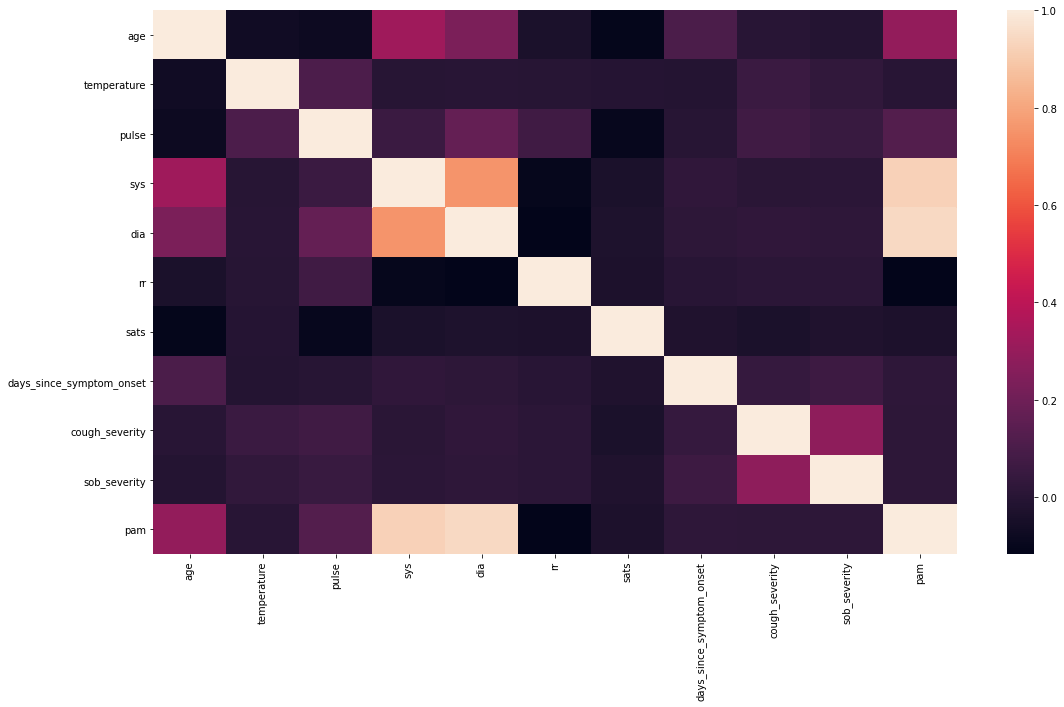

In [10]:
plt.figure(figsize=(18, 10))
sns.heatmap(pd.concat([X[significance_tests.index], pam], axis=1).corr(), xticklabels=list(significance_tests.index) + ["pam"], yticklabels= list(significance_tests.index) + ["pam"])
plt.show()

The new feature seems to be quite strong at predicting results since it's p-value is below our significance level so I added it to the `DataImputer` class. Also, as we can see above, <b>sys</b> and <b>dia</b> result to be highly correlated with each other as well as to a certain degree with other variables while <b>pam</b> does not seem to be correlated with anything but <b>age</b> to a lesser extent. Because of that, I will drop them during imputation.

### $\chi^{2}$ tests for independence between the covid test result and each categorial feature's values

$\alpha$: 0.005<br>

In [11]:
categorical_columns = [x for x in X.columns if X[x].dtype != "float64" or x == "cough_severity" or x == "sob_severity"]

values = []
for column in categorical_columns:
    
    a = all_data.groupby(by=["covid19_test_results", column], as_index=False).size().pivot(index=column, columns="covid19_test_results")
    
    #This is the formula for calculating the expected values of each cell:
    # - The a/a is just to make sure the matrix becomes 1
    # - The formula states that we have to calculate the probability of each cell, multiply those probabilities, and then multiply them by n. Doing algebra we arrive at the formula below
    #   (X/n) is the prob of X. (A/n) is the prob of A. To obtain the expected value of cell AX we do n*(X/n)*(A/n), which can just be reduced to (X*A)/n
    expected_values = (a/a) * (a.sum(axis=0)/a.values.sum()) * (a.sum(axis=1).values.reshape((a.shape[0], 1)))
        
    values.append(chisquare(f_obs=a.values.flatten(), f_exp=expected_values.values.flatten()))

chisquare_tests = pd.DataFrame(values, index=categorical_columns, columns=["chi-statistic", "p-value"])
chisquare_tests.style.apply(highlight_max) 

,chi-statistic,p-value
age,13.313841,0.064821
high_risk_exposure_occupation,29.764927,0.000002
high_risk_interactions,9.141420,0.027469
diabetes,15.903699,0.001187
chd,0.072217,0.994949
htn,0.048312,0.997216
cancer,0.016782,0.999425
asthma,4.264574,0.234276
autoimmune_dis,1.766320,0.622291
smoker,1.873253,0.599126


### Combine the most important numeric and categorical features according to the significance levels

In [12]:
numerical_features = significance_tests[significance_tests["p-value"] < 0.005].index
categorical_features = chisquare_tests[chisquare_tests["p-value"] < 0.005].index
selected_features = numerical_features.union(categorical_features)
print(len(selected_features))
selected_features

23


Index(['cough', 'cough_severity', 'ctab', 'days_since_symptom_onset', 'dia',
       'diabetes', 'diarrhea', 'fatigue', 'fever', 'headache',
       'high_risk_exposure_occupation', 'loss_of_smell', 'loss_of_taste',
       'muscle_sore', 'pulse', 'rhonchi', 'rr', 'runny_nose', 'sob',
       'sob_severity', 'sore_throat', 'temperature', 'wheezes'],
      dtype='object')

In [13]:
selected_features = selected_features.union(["sys", "dia"]) #Since both are necessary to calculate the PAM we must include them too
selected_features

Index(['cough', 'cough_severity', 'ctab', 'days_since_symptom_onset', 'dia',
       'diabetes', 'diarrhea', 'fatigue', 'fever', 'headache',
       'high_risk_exposure_occupation', 'loss_of_smell', 'loss_of_taste',
       'muscle_sore', 'pulse', 'rhonchi', 'rr', 'runny_nose', 'sob',
       'sob_severity', 'sore_throat', 'sys', 'temperature', 'wheezes'],
      dtype='object')

## Model development

In [18]:
models ={
    "GaussianNB" : GaussianNB(),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=100),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression(),
    "Ada Boost" : AdaBoostClassifier()
}

GaussianNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVM
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Scores on training data, validation data and 95% confidence interval for validation score


,Training Score,Validation Score,Confidence Interval
GaussianNB,0.128596,0.129093,0.117974-0.140213
Random Forest (100 estimators),0.121767,0.000000,0.0-0.0
XGBoost Classifier,0.853517,0.057596,0.037694-0.077498
SVM,0.000308,0.000000,0.0-0.0
KNN,0.994929,0.017734,0.006267-0.0292
Logistic Regression,0.062401,0.061946,0.040603-0.08329
Ada Boost,0.632754,0.068634,0.049303-0.087965


Performance over different classification thresholds


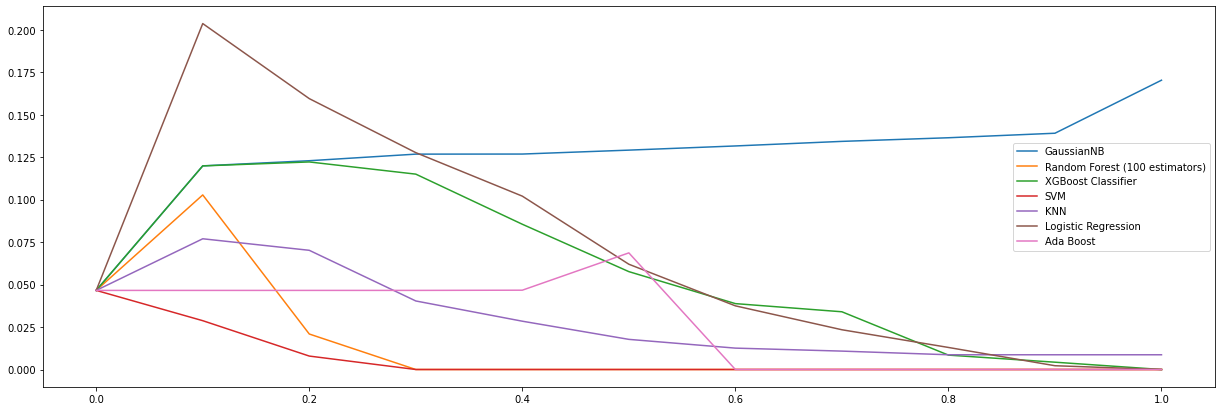

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
GaussianNB,0.04655,0.119841,0.122859,0.126736,0.126784,0.129093,0.131551,0.134241,0.136377,0.139035,0.170241
Random Forest (100 estimators),0.04655,0.102736,0.020890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost Classifier,0.04655,0.119805,0.122138,0.114967,0.085474,0.057596,0.038771,0.033971,0.008468,0.004301,0.000000
SVM,0.04655,0.028727,0.007909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.04655,0.076930,0.070143,0.040331,0.028425,0.017734,0.012579,0.010824,0.008674,0.008674,0.008674
Logistic Regression,0.04655,0.203563,0.159405,0.127612,0.102014,0.061946,0.037457,0.023392,0.012975,0.002222,0.000000
Ada Boost,0.04655,0.046550,0.046550,0.046551,0.046674,0.068634,0.000000,0.000000,0.000000,0.000000,0.000000


In [163]:
run_models(X[selected_features], y, models, folds=30, ratio_negatives_to_positives=0)

GaussianNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVM
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Scores on training data, validation data and 95% confidence interval for validation score


,Training Score,Validation Score,Confidence Interval
GaussianNB,0.582043,0.111021,0.103487-0.118555
Random Forest (100 estimators),0.866381,0.047485,0.046299-0.048671
XGBoost Classifier,0.999343,0.064111,0.060658-0.067564
SVM,0.762598,0.058716,0.049913-0.067519
KNN,0.999961,0.045636,0.042935-0.048337
Logistic Regression,0.746380,0.068085,0.062552-0.073618
Ada Boost,0.894821,0.064353,0.059869-0.068837


Performance over different classification thresholds


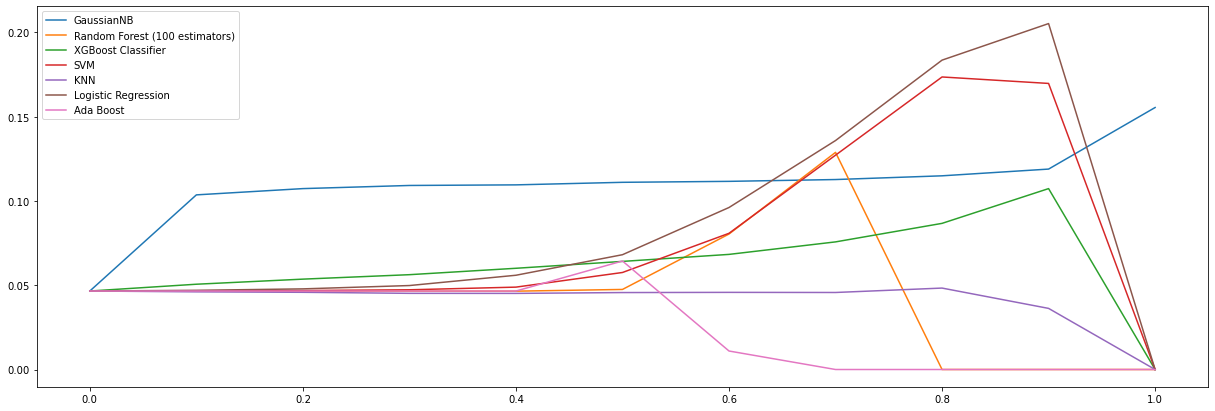

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
GaussianNB,0.04655,0.103574,0.107291,0.109154,0.109508,0.111021,0.111590,0.112668,0.114876,0.118869,0.155386
Random Forest (100 estimators),0.04655,0.046550,0.046561,0.046503,0.046463,0.047485,0.080352,0.128784,0.000000,0.000000,0.000000
XGBoost Classifier,0.04655,0.050579,0.053596,0.056239,0.060037,0.064111,0.068273,0.075687,0.086677,0.107292,0.000000
SVM,0.04655,0.046686,0.046824,0.047285,0.048858,0.057538,0.080784,0.127123,0.173503,0.169668,0.000000
KNN,0.04655,0.046058,0.045788,0.045173,0.045141,0.045636,0.045750,0.045681,0.048296,0.036246,0.000000
Logistic Regression,0.04655,0.046969,0.047821,0.049797,0.055903,0.068085,0.096082,0.135797,0.183489,0.205170,0.000000
Ada Boost,0.04655,0.046550,0.046550,0.046550,0.046544,0.064353,0.010968,0.000000,0.000000,0.000000,0.000000


In [26]:
run_models(X, y, models, folds=30, ratio_negatives_to_positives=1)

GaussianNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Scores on training data, validation data and 95% confidence interval for validation score


,Training Score,Validation Score,Confidence Interval
GaussianNB,0.592874,0.116889,0.109044-0.124733
Random Forest (100 estimators),0.973349,0.086542,0.080884-0.092201
XGBoost Classifier,0.996759,0.116805,0.09557-0.138041
KNN,0.999974,0.048967,0.047448-0.050487
Logistic Regression,0.768214,0.067312,0.06505-0.069573
Ada Boost,0.969787,0.121945,0.102968-0.140922


Performance over different classification thresholds


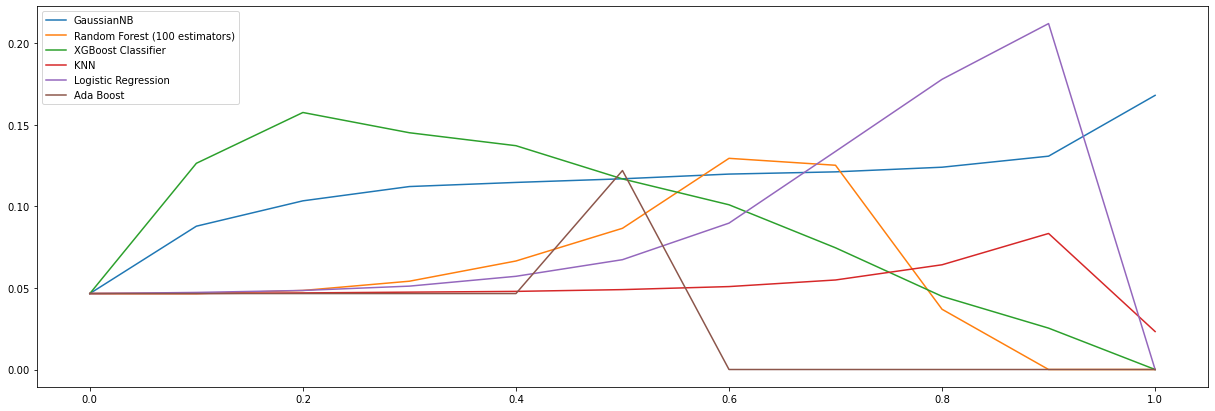

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
GaussianNB,0.04655,0.087836,0.103377,0.112138,0.114662,0.116889,0.119775,0.121136,0.123989,0.130755,0.168024
Random Forest (100 estimators),0.04655,0.046498,0.048444,0.054117,0.066502,0.086542,0.129431,0.125184,0.036916,0.000000,0.000000
XGBoost Classifier,0.04655,0.126387,0.157523,0.145110,0.137174,0.116805,0.100965,0.074589,0.044838,0.025353,0.000000
KNN,0.04655,0.046577,0.046942,0.047413,0.047879,0.048967,0.050825,0.054870,0.064189,0.083374,0.023274
Logistic Regression,0.04655,0.047235,0.048453,0.051100,0.057123,0.067312,0.089718,0.133665,0.177862,0.212022,0.000000
Ada Boost,0.04655,0.046550,0.046550,0.046550,0.046550,0.121945,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
run_models(X, y, models, folds=30, ratio_negatives_to_positives=-1)

The best model seems to be <b>Logistic Regression</b>, followed by <b>Random Forest</b> and in third place we have <b>SVM</b>. The criteria used was the model which performed the best, followed by the 2 second best performances at a threshold of 50%.

### Logistic Regression

In [21]:
logistic_model_group = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "LogisticNoPenalty" : LogisticRegression(penalty="none"),
    "Logistic NewtonSolver" : LogisticRegression(solver="newton-cg"),
    "Logistic NewtonSolver No penalty" : LogisticRegression(solver="newton-cg", penalty="none"),    
    "Logistic LibLinear" : LogisticRegression(solver="liblinear")
}

LogisticVanilla
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

LogisticStrongRegularization
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

LogisticWeakRegularization
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

LogisticNoPenalty
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic NewtonSolver
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic NewtonSolver No penalty
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic LibLinear
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Scores on training data, validation data and 95% confidence interval for validation score


,Training Score,Validation Score,Confidence Interval
LogisticVanilla,0.714898,0.077569,0.069455-0.085683
LogisticStrongRegularization,0.728323,0.070411,0.064132-0.076689
LogisticWeakRegularization,0.720526,0.075793,0.068524-0.083062
LogisticNoPenalty,0.722292,0.072480,0.065825-0.079135
Logistic NewtonSolver,0.727590,0.070639,0.064378-0.0769
Logistic NewtonSolver No penalty,0.740619,0.067172,0.060336-0.074007
Logistic LibLinear,0.731824,0.067736,0.062694-0.072778


Performance over different classification thresholds


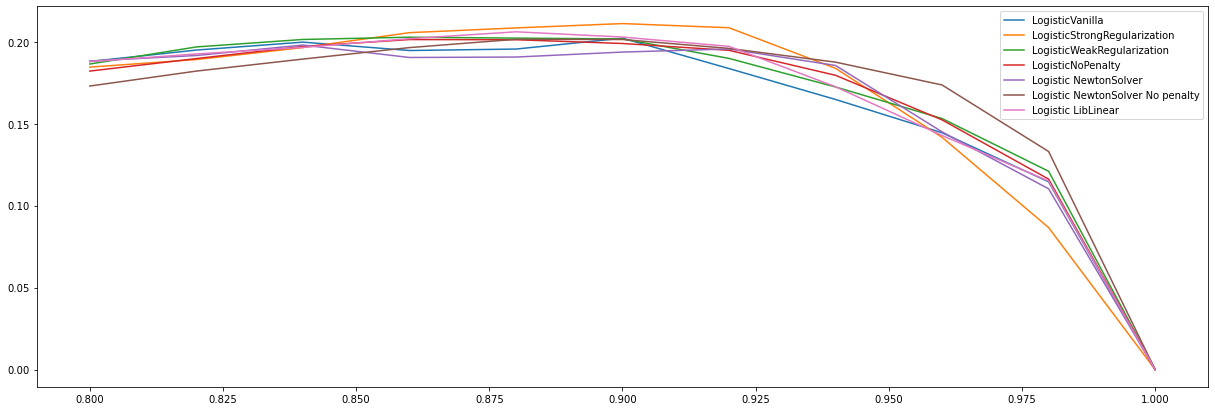

,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
LogisticVanilla,0.187903,0.194867,0.199690,0.194586,0.195475,0.202087,0.183578,0.164727,0.144409,0.114502,0.0
LogisticStrongRegularization,0.184455,0.189078,0.196378,0.205478,0.208365,0.211016,0.208487,0.183721,0.141647,0.086607,0.0
LogisticWeakRegularization,0.186350,0.196766,0.201327,0.202702,0.202150,0.201669,0.189768,0.172350,0.153104,0.120946,0.0
LogisticNoPenalty,0.182036,0.189667,0.197085,0.201268,0.201156,0.198873,0.194699,0.179468,0.152275,0.116151,0.0
Logistic NewtonSolver,0.188176,0.191539,0.197916,0.190335,0.190603,0.193636,0.195515,0.185458,0.144960,0.110238,0.0
Logistic NewtonSolver No penalty,0.172919,0.182031,0.189365,0.196360,0.201423,0.201299,0.195870,0.187490,0.173572,0.132990,0.0
Logistic LibLinear,0.187798,0.192481,0.196491,0.201798,0.205999,0.202795,0.197112,0.172494,0.142757,0.114975,0.0


In [31]:
run_models(X[selected_features], y, logistic_model_group, folds=30, ratio_negatives_to_positives=1, thresholds=np.linspace(.8,1,num=11))

### SVM

In [28]:
svm_model_group = {
    "SVC 0.5" : SVC(C=0.5, probability=True),
    "SVC 1" : SVC(C=1, probability=True),
    "SVC 1.5" : SVC(C=1.5, probability=True),
    "SVC 2" : SVC(C=2, probability=True),
    "SVC linear 0.5" : SVC(C=0.5, kernel="linear", probability=True),
    "SVC linear 1" : SVC(C=1, kernel="linear", probability=True),
    "SVC linear 1.5" : SVC(C=1.5, kernel="linear", probability=True),
    "SVC linear 2" : SVC(C=2, kernel="linear", probability=True),
}


SVC 0.5
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC 1
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC 1.5
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC 2
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC linear 0.5
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC linear 1
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC linear 1.5
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVC linear 2
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Scores on training data, validation data and 95% confidence interval for validation score


,Training Score,Validation Score,Confidence Interval
SVC 0.5,0.829470,0.045918,0.04262-0.049216
SVC 1,0.850829,0.045041,0.044138-0.045944
SVC 1.5,0.848202,0.045374,0.044298-0.04645
SVC 2,0.860711,0.045512,0.044507-0.046517
SVC linear 0.5,0.740747,0.067672,0.056759-0.078585
SVC linear 1,0.747639,0.061341,0.052294-0.070388
SVC linear 1.5,0.754500,0.066309,0.054947-0.077672
SVC linear 2,0.767344,0.056686,0.049752-0.063621


Performance over different classification thresholds


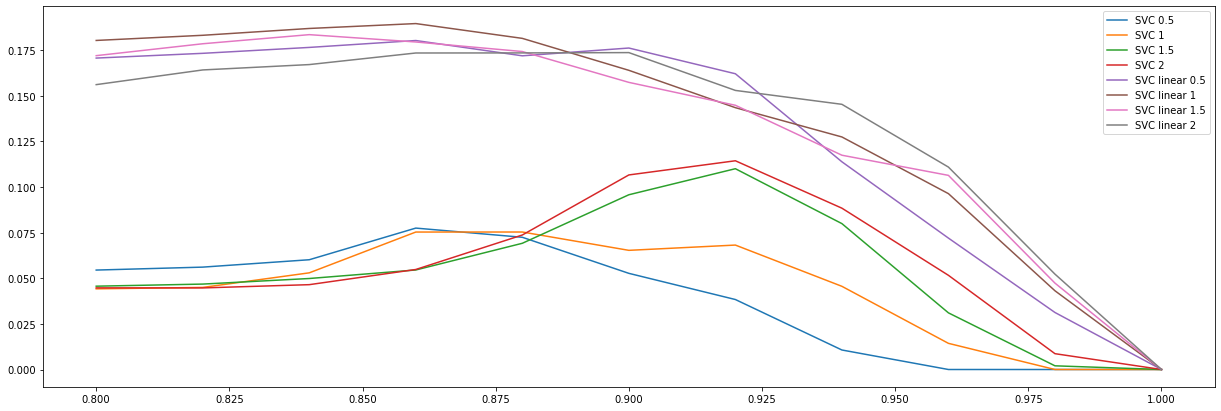

,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
SVC 0.5,0.054492,0.056107,0.060154,0.077495,0.072461,0.052698,0.038349,0.010690,0.000000,0.000000,0.0
SVC 1,0.044202,0.044989,0.052975,0.075331,0.075347,0.065304,0.068191,0.045588,0.014335,0.000000,0.0
SVC 1.5,0.045661,0.046810,0.049868,0.054542,0.069173,0.095762,0.110039,0.079949,0.031044,0.002020,0.0
SVC 2,0.044738,0.044710,0.046494,0.054810,0.073710,0.106625,0.114390,0.088409,0.051615,0.008674,0.0
SVC linear 0.5,0.170670,0.173271,0.176509,0.180289,0.171908,0.176176,0.162079,0.113825,0.072010,0.031248,0.0
SVC linear 1,0.180329,0.183156,0.186896,0.189575,0.181468,0.163959,0.143487,0.127438,0.096373,0.043145,0.0
SVC linear 1.5,0.171996,0.178516,0.183508,0.179493,0.174258,0.157354,0.144806,0.117435,0.106391,0.047342,0.0
SVC linear 2,0.156116,0.164167,0.167107,0.173453,0.173494,0.173669,0.152946,0.145327,0.110925,0.052267,0.0


In [41]:
run_models(X[selected_features], y, svm_model_group, folds=30, ratio_negatives_to_positives=1, thresholds=np.linspace(.8,1,num=11))

### Random Forest

In [24]:
rf_model_group = {
    "Random Forest (100 estimators)" : RandomForestClassifier(),
    "Random Forest (300 estimators)" : RandomForestClassifier(n_estimators=300),
    "Random Forest (500 estimators)" : RandomForestClassifier(n_estimators=500),
    "Random Forest (entropy)" : RandomForestClassifier(criterion="entropy"),
    "Random Forest (300 estimators and entropy)" : RandomForestClassifier(n_estimators=300, criterion="entropy"),
    "Random Forest (500 estimators and entropy)" : RandomForestClassifier(n_estimators=500, criterion="entropy")
}

Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (300 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (500 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (entropy)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (300 estimators and entropy)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (500 estimators and entropy)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Scores on training data, validation data and 95% confidence interval for validation score


,Training Score,Validation Score,Confidence Interval
Random Forest (100 estimators),0.999498,0.054399,0.052386-0.056412
Random Forest (300 estimators),0.999633,0.055801,0.054089-0.057514
Random Forest (500 estimators),0.999440,0.054764,0.053133-0.056395
Random Forest (entropy),0.999517,0.057841,0.056105-0.059578
Random Forest (300 estimators and entropy),0.999517,0.055685,0.053815-0.057555
Random Forest (500 estimators and entropy),0.999478,0.056270,0.054474-0.058066


Performance over different classification thresholds


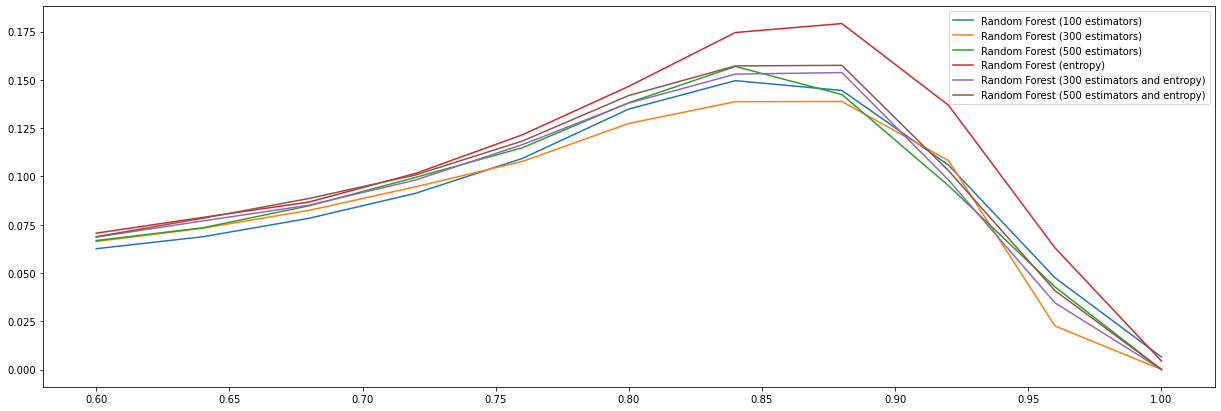

,0.60,0.64,0.68,0.72,0.76,0.80,0.84,0.88,0.92,0.96,1.00
Random Forest (100 estimators),0.062550,0.068741,0.078331,0.091277,0.109302,0.134881,0.149580,0.144516,0.105881,0.047517,0.006452
Random Forest (300 estimators),0.066298,0.073142,0.082434,0.094650,0.107740,0.127435,0.138685,0.138797,0.108232,0.022557,0.000000
Random Forest (500 estimators),0.066769,0.073388,0.084795,0.099539,0.114834,0.138177,0.156940,0.142382,0.095226,0.042770,0.000000
Random Forest (entropy),0.070598,0.078762,0.086755,0.101595,0.121525,0.146660,0.174518,0.179140,0.136888,0.063016,0.004373
Random Forest (300 estimators and entropy),0.068573,0.076941,0.085099,0.098153,0.116441,0.137958,0.152965,0.153763,0.098207,0.034495,0.000000
Random Forest (500 estimators and entropy),0.068764,0.078316,0.088599,0.100773,0.118300,0.141895,0.157206,0.157517,0.103014,0.040852,0.000000


In [32]:
run_models(X[selected_features], y, rf_model_group, folds=30, ratio_negatives_to_positives=1, thresholds=np.linspace(.6,1,num=11))

After examining all three models, <b>logistic regression</b> seems to be the best model at a <b>threshold of .46 with no penalty</b>

## Final Evaluation

In [37]:
eval_final_performance(X[selected_features], y, test_x, test_y, logistic_model_group["LogisticStrongRegularization"], threshold=.9)

[Pipeline] ........... (step 1 of 2) Processing Imputer, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing Model, total=   0.0s
Training done... predictiong results
Done! Doing dummy models now
Confusion matrix


,0,1
0,12306,312
1,237,60


,Accuracy,Recall,Precision,Specificiy,F1
Training Data,0.609865,0.238789,0.926087,0.980942,0.379679
Test Data,0.957491,0.202020,0.161290,0.975273,0.179372
Random 50/50,0.505304,0.457912,0.021370,0.506419,0.040835
Random stratified,0.499574,0.471380,0.021719,0.500238,0.041525


In [38]:
eval_final_performance_smote(X[selected_features], y, test_x, test_y, logistic_model_group["LogisticStrongRegularization"], threshold=.9)

Training done... predictiong results
Done! Doing dummy models now
Confusion matrix


,0,1
0,12349,269
1,240,57


,Accuracy,Recall,Precision,Specificiy,F1
Training Data,0.962392,0.220852,0.205422,0.979868,0.212858
Test Data,0.960588,0.191919,0.174847,0.978681,0.182986
Random 50/50,0.498877,0.491582,0.022576,0.499049,0.043170
Random stratified,0.955788,0.023569,0.024306,0.977730,0.023932


## Pipeline Experiments

In [35]:
def cross_validation_sklearn(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, 
                                  thresholds=np.linspace(0,1,num=11), sample_weights=None):
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = data_y[data_y == "Negative"].shape[0]
    negs_to_sample = min(positive_index.shape[0] * ratio_negatives_to_positives, size_of_negatives) if ratio_negatives_to_positives >=1 else size_of_negatives
        
    imputer = DataImputer()
    
    new_X = pd.concat([data_x[data_y == "Positive"], data_x[data_y=="Negative"].sample(negs_to_sample)], axis=0)
    new_y = data_y[new_X.index]
        
    pipeline = Pipeline([("Imputer", imputer),
                            ("Model", model)])
    
    #Code to just test with a single split
    tx, vx, ty, vy = train_test_split(data_x, data_y, test_size=.1, stratify=data_y)
    pipeline.fit(tx, ty)
    print(f1_score(vy, pipeline.predict(vx), pos_label="Positive"))
    #End block
    
    pipeline = Pipeline([("Imputer", imputer),
                            ("Model", model)])
    return cross_val_score(estimator=pipeline, X=new_X, y=new_y, cv=folds, error_score=-1, scoring=make_scorer(f1_score, pos_label="Positive"))
    

def cross_validation_smote(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, 
                                  thresholds=np.linspace(0,1,num=11), sample_weights=None):
    
    imputer = DataImputer()
    print()
    smote = SMOTE(sampling_strategy=1/ratio_negatives_to_positives, random_state=0)   
    
    pipeline = ImbPipeline([("Imputer", imputer),
                         ("SMOTE", smote),
                            ("Model", model)])
    
    return cross_val_score(estimator=pipeline, X=data_x, y=data_y, cv=folds, error_score=-1, scoring=make_scorer(f1_score, pos_label="Positive"))